# Dictionary Learning based Beamformer

Parameters to investigate:
* Number of interferences in training vs testing
* Interferences angles in training vs testing
* Interference power in training vs testing
* Number of snapshots and training samples in training
* Input SNR
* Number of microphones

### Setup
Interference angles are assumed to be the same for both training and testing.
### *Questions*
* How does DLBeamformer depend on the input SNR?
* Assume that the input SNR is fixed. How do (1) interference power in testing and (2) interference power mismatch in training vs testing affect DLBeamformer performance?

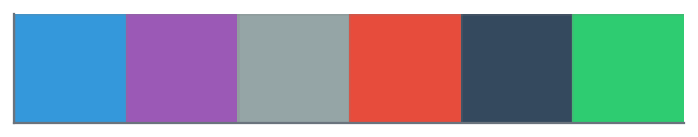

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui); current_palette = sns.color_palette(); 
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')

from tqdm import tnrange, tqdm_notebook
from dlbeamformer_utilities import compute_steering_vector_ULA, compute_MVDR_weight, \
    check_distortless_constraint, uniform_linear_array, \
    generate_gaussian_samples, generate_gaussian_training_data, compute_steering_vector_ULA_new
from dlbeamformer import MicrophoneArray, BaseDLBeamformer
from config import sound_speed
sns.palplot(current_palette)

random_seed = 10

#### Setup

In [2]:
d = 0.5
frequency = sound_speed
n_mics = 10
array_geometry = uniform_linear_array(n_mics=n_mics, spacing=d)
microphone_array = MicrophoneArray(array_geometry)
theta_s = 0
us = np.cos( theta_s * np.pi/180 )
# vs = compute_steering_vector_ULA(us, microphone_array)
vs = compute_steering_vector_ULA_new(microphone_array, theta_s, frequency)
SNRs = np.arange(0, 31, 10)
n_SNRs = len(SNRs)
noise_sigma = 1

#### Training data

In [3]:
training_snapshots = [10, 100]
interference_power_list = [10, 20, 30]
n_interference_list = [1, 2, 3]
n_training_samples = 1
u_step = 0.1
u_list = np.arange(0, 1+1e-6, u_step)

training_snapshots = [200]
training_interference_power_list = [30, 40, 50]
training_n_interference_list = [2]

training_theta_list = [45, 90]
training_u_list = [ np.cos( training_theta * np.pi/180 ) for training_theta in training_theta_list]
# training_u_list = [0.29, 0.45, 0.7]

np.random.seed(random_seed)
training_noise_interference_data_various_snapshots = generate_gaussian_training_data(
    microphone_array, training_snapshots, training_n_interference_list,
    training_u_list, training_interference_power_list, n_training_samples, noise_sigma)

#### Train baseline dictionary

In [4]:
np.random.seed(random_seed)
dictionaries = []
for i_training_snapshot in range(len(training_snapshots)):
    training_noise_interference_data = training_noise_interference_data_various_snapshots[i_training_snapshot]
    dictionary = BaseDLBeamformer(vs)
    dictionary.fit(training_noise_interference_data);
    dictionaries.append(dictionary)

#### Testing

In [5]:
np.random.seed(random_seed)
n_trials = 200
snapshots = np.array([10, 20, 30, 40, 60, 100, 200, 500, 1000])
n_snapshots = len(snapshots)

u_list = training_u_list
theta_list = training_theta_list
n_interferences_list = [len(u_list)]
n_interferences = len(u_list)
INR_list = [10, 20, 30, 40]
n_INRs = len(INR_list)
source_SNR = SNRs[0]

sinr_snr_mvdr = np.zeros((n_SNRs, n_INRs, n_snapshots))
sinr_snr_mpdr = np.zeros((n_SNRs, n_INRs, n_snapshots))
sinr_snr_baseline_mpdr = np.zeros((len(training_snapshots), n_SNRs, n_INRs, n_snapshots))
sinr_snr_baseline_mvdr = np.zeros((len(training_snapshots), n_SNRs, n_INRs, n_snapshots))

for i_SNR in tqdm_notebook(range(n_SNRs), desc="SNR"):
    source_SNR = SNRs[i_SNR]
    sigma_s = 10**(source_SNR / 10)
    Rs = sigma_s * vs.dot(vs.transpose().conjugate())
    
    for i_INR in tqdm_notebook(range(n_INRs), desc="INR"):        
        interference_power = INR_list[i_INR]
        
        for i_snapshot in tqdm_notebook(range(n_snapshots), desc="Snapshots", leave=False):
            snapshot = snapshots[i_snapshot]
            sinr_mvdr = np.zeros(n_trials)
            sinr_mpdr = np.zeros(n_trials)
            sinr_baseline_mpdr = np.zeros((len(training_snapshots), n_trials))
            sinr_baseline_mvdr = np.zeros((len(training_snapshots), n_trials))

            for i_trial in range(n_trials):
                ss = np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) + 1j*np.sqrt(sigma_s/2)*np.random.randn(1, snapshot) # signal samples            
                nn = np.sqrt(noise_sigma/2)*np.random.randn(microphone_array.n_mics, snapshot) + 1j*np.sqrt(noise_sigma/2)*np.random.randn(microphone_array.n_mics, snapshot) # Gaussian noise samples

                nv = np.zeros((microphone_array.n_mics, snapshot), dtype=complex)
                Rn = np.zeros((microphone_array.n_mics, microphone_array.n_mics), dtype=complex)
                for i_interference in range(n_interferences):
                    u = u_list[i_interference]
                    theta = theta_list[i_interference]
                    sigma = 10**(interference_power/10)     
                    ii = generate_gaussian_samples(power=sigma, shape=(1, snapshot))
                    interference_steering_vector_old = compute_steering_vector_ULA(u, microphone_array)
                    interference_steering_vector = compute_steering_vector_ULA_new(microphone_array, theta, frequency)
                    assert np.linalg.norm(interference_steering_vector_old - interference_steering_vector) < 1e-6
                    nv += interference_steering_vector*ii
                    Rn += sigma*interference_steering_vector.dot(interference_steering_vector.transpose().conjugate())
                nv += nn
                Rn += noise_sigma*np.identity(microphone_array.n_mics)
                Rninv = np.linalg.inv(Rn)

                sv = vs*ss
                xx = sv + nv

                for i_dictionary in range(len(dictionaries)):
                    dictionary = dictionaries[i_dictionary]
                    w_baseline_p = dictionary.choose_weights(xx)
                    sinr_baseline_mpdr[i_dictionary, i_trial] = np.real(w_baseline_p.transpose().conjugate().dot(Rs).dot(w_baseline_p)) / np.real(w_baseline_p.transpose().conjugate().dot(Rn).dot(w_baseline_p))
                    w_baseline_v = dictionary.choose_weights(nv)
                    sinr_baseline_mvdr[i_dictionary, i_trial] = np.real(w_baseline_v.transpose().conjugate().dot(Rs).dot(w_baseline_v)) / np.real(w_baseline_v.transpose().conjugate().dot(Rn).dot(w_baseline_v))                            
                    check_distortless_constraint(w_baseline_p, vs)
                    check_distortless_constraint(w_baseline_v, vs)
                wv = compute_MVDR_weight(vs, nv)
                wp = compute_MVDR_weight(vs, xx)

                check_distortless_constraint(wv, vs)
                check_distortless_constraint(wp, vs)

                sinr_mvdr[i_trial] = np.real(wv.transpose().conjugate().dot(Rs).dot(wv)) / np.real(wv.transpose().conjugate().dot(Rn).dot(wv))
                sinr_mpdr[i_trial] = np.real(wp.transpose().conjugate().dot(Rs).dot(wp)) / np.real(wp.transpose().conjugate().dot(Rn).dot(wp))
            
            sinr_snr_mvdr[i_SNR, i_INR, i_snapshot] = np.sum(sinr_mvdr) / n_trials
            sinr_snr_mpdr[i_SNR, i_INR, i_snapshot] = np.sum(sinr_mpdr) / n_trials

            for i_dictionary in range(len(dictionaries)):
                sinr_snr_baseline_mpdr[i_dictionary, i_SNR, i_INR, i_snapshot] = np.sum(sinr_baseline_mpdr[i_dictionary, :]) / n_trials
                sinr_snr_baseline_mvdr[i_dictionary, i_SNR, i_INR, i_snapshot] = np.sum(sinr_baseline_mvdr[i_dictionary, :]) / n_trials

##### Dependence of Baseline DLBeamformer on the input SNR

When the interferences are fixed, the MPDR DLBeamformer using the received data samples performs worse as the source gets stronger. This might be due to the fact that the input source in $received \ data = source + interference + noise$ dominates the other elements which in turns confuses the MPDR DLBeamformer. In the figure below, the gap between MPDR DLBeamformer and MVDR DLBeamformer gets bigger as the input SNR increases.

Number of training snapshots: 200


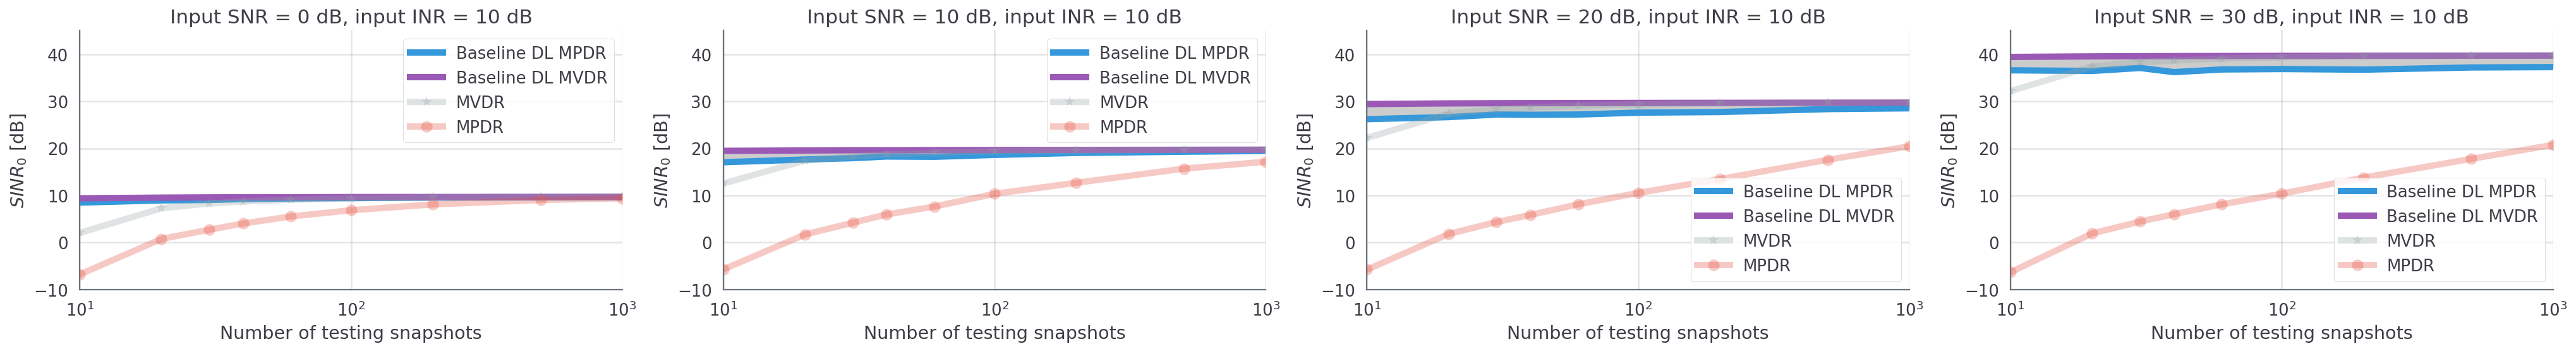

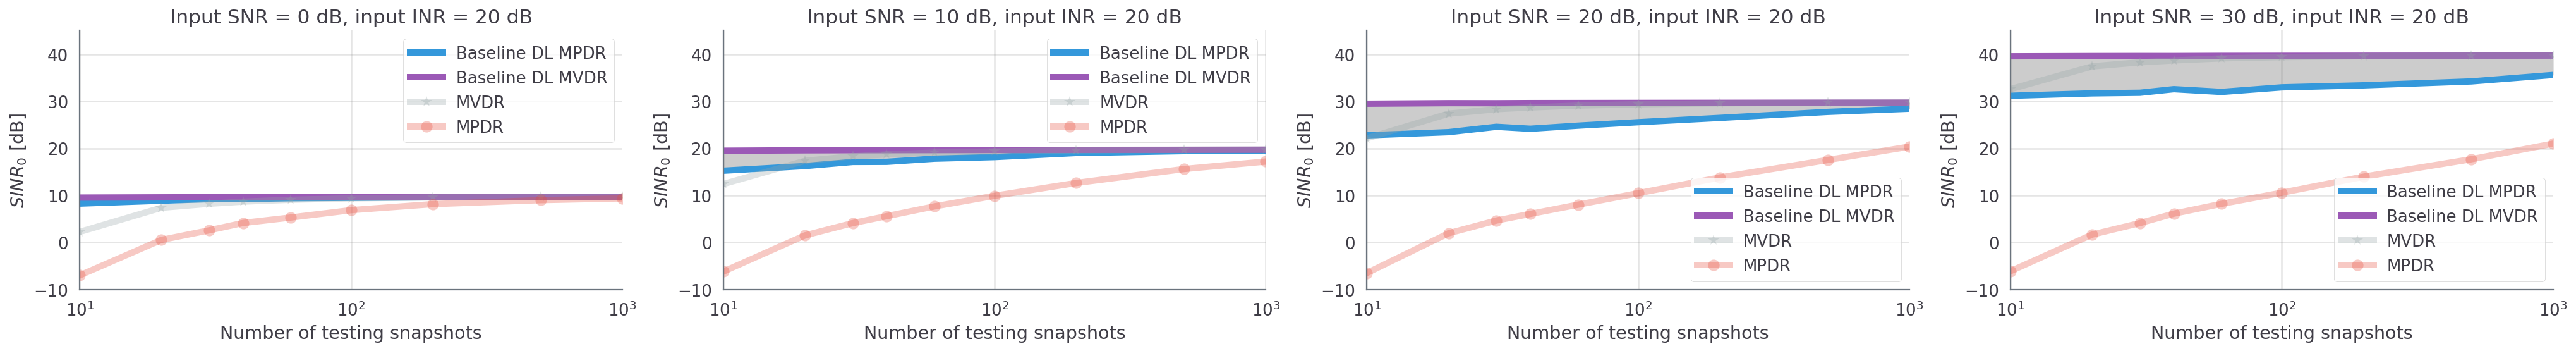

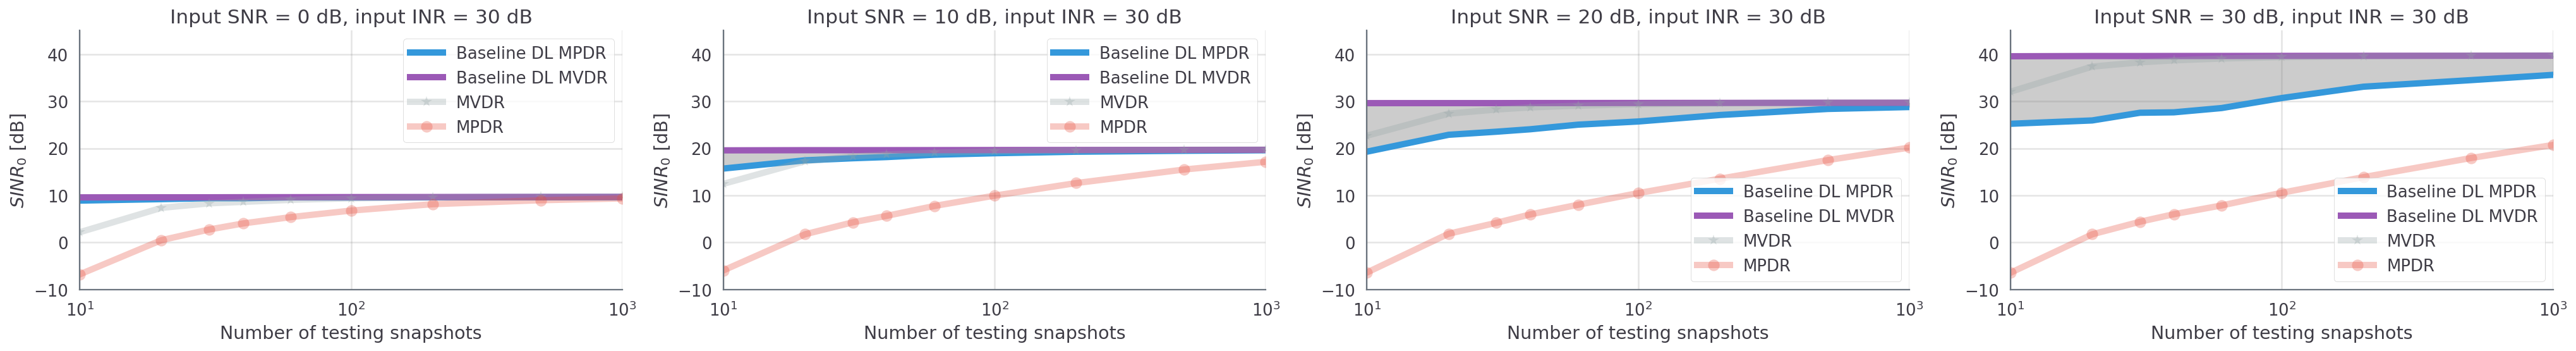

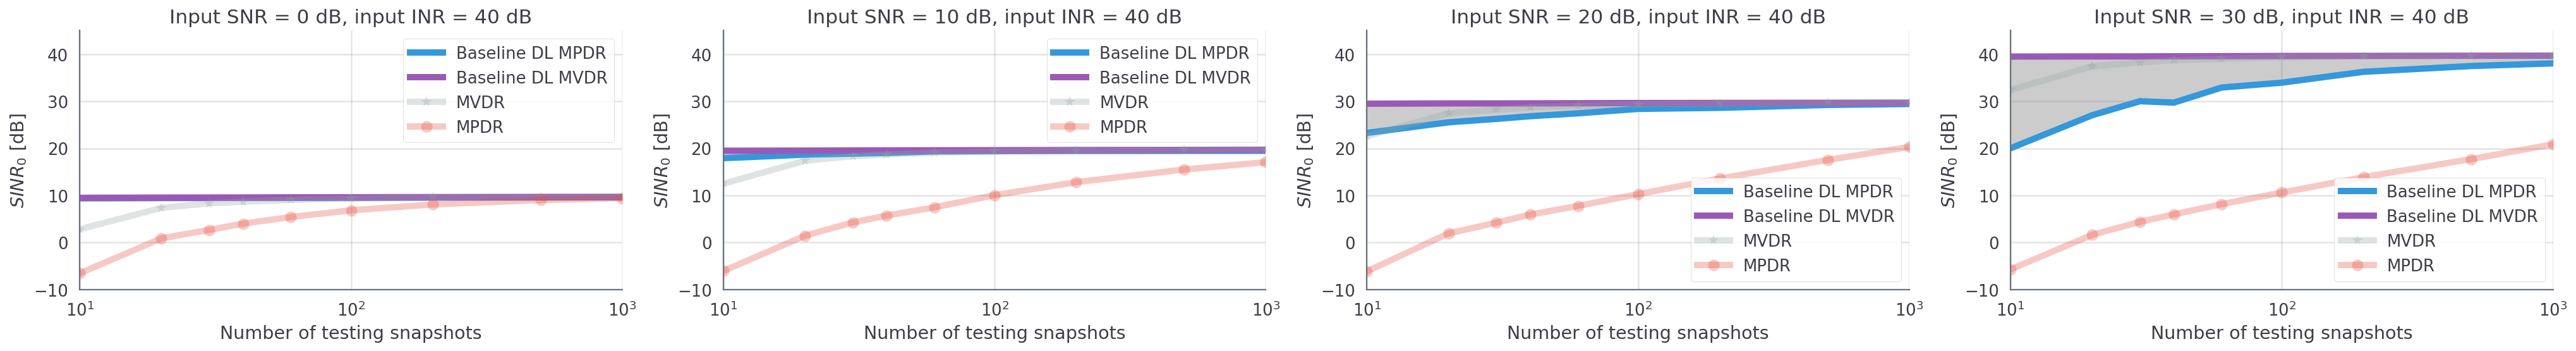

In [6]:
lw = 5
print("Number of training snapshots: {}".format(training_snapshots[0]))
from matplotlib.figure import figaspect
w, h = figaspect(9/16)
for i_INR in range(n_INRs):
    fig = plt.figure(figsize=(w*n_SNRs, h));
    for i_SNR in range(n_SNRs):
        ax = fig.add_subplot(1, n_SNRs, i_SNR+1)
        for i_training_snapshot in range(len(training_snapshots)):
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MPDR", lw=lw)
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MVDR", lw=lw)
            ax.fill_between(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, i_INR, :]),
                                       10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]), color='0.8')
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, i_INR, :]), marker="*", alpha=0.3, label="MVDR", lw=lw)
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, i_INR, :]), marker="o", alpha=0.3, label="MPDR", lw=lw)
        ax.legend()
        ax.set_xlim(10, 1000); ax.set_ylim(-10, 45);
        ax.set_xlabel("Number of testing snapshots");
        ax.set_ylabel(r"$SINR_0$ [dB]");
        ax.set_title("Input SNR = {} dB, input INR = {} dB".format(SNRs[i_SNR], INR_list[i_INR]))
    plt.tight_layout()    
    # fig.savefig("baseline_dl_various_interferences.jpg", dpi=600)    

##### Dependence of Baseline DLBeamformer on the interference INRs
When the input SNR is fixed, the Baseline DLBeamformer works worse as the input interferences get stronger. In the figures below, the gap between MVDR DLBeamformer vs Optimal MVDR Beamformer becomes larger when the input interferences are more severe.

Number of training snapshots: 200


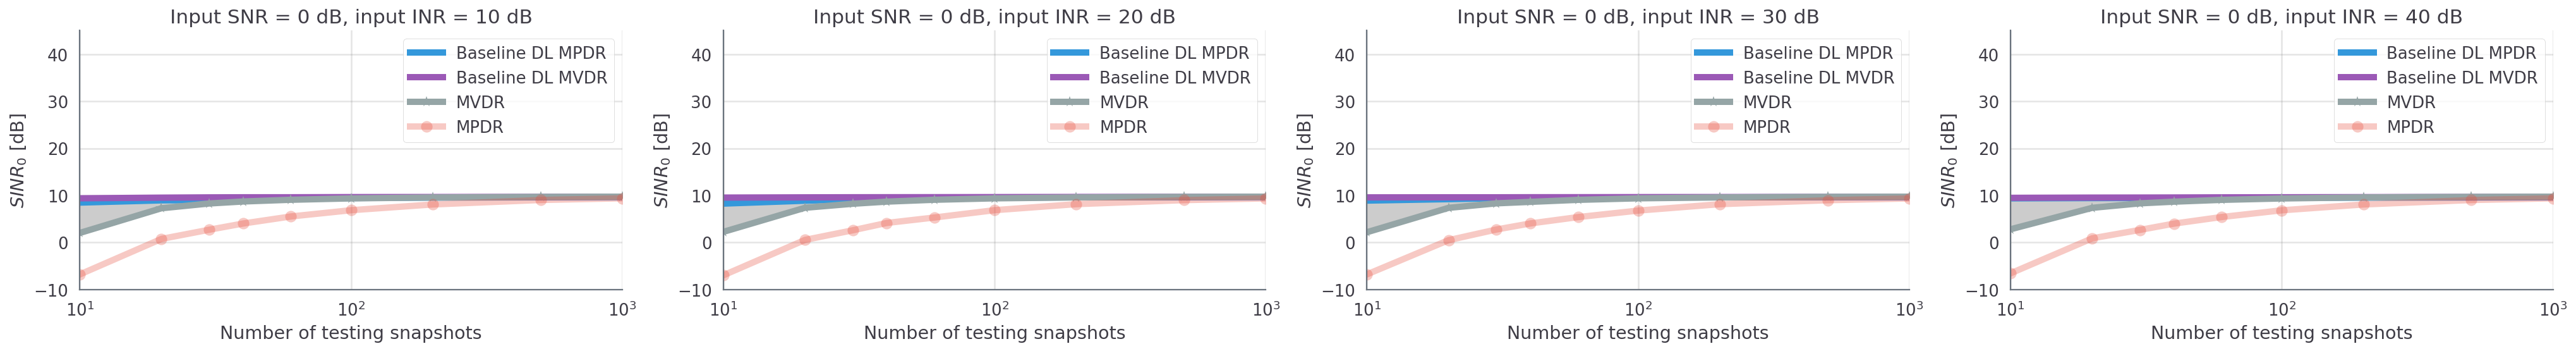

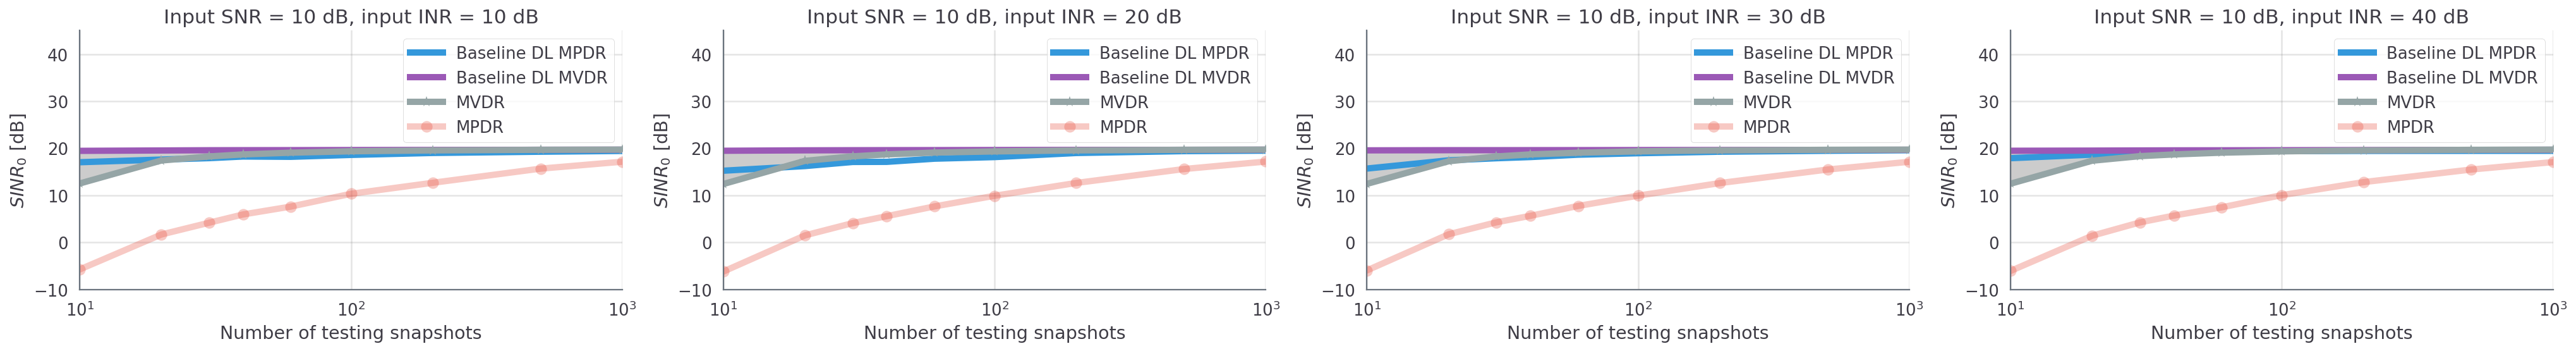

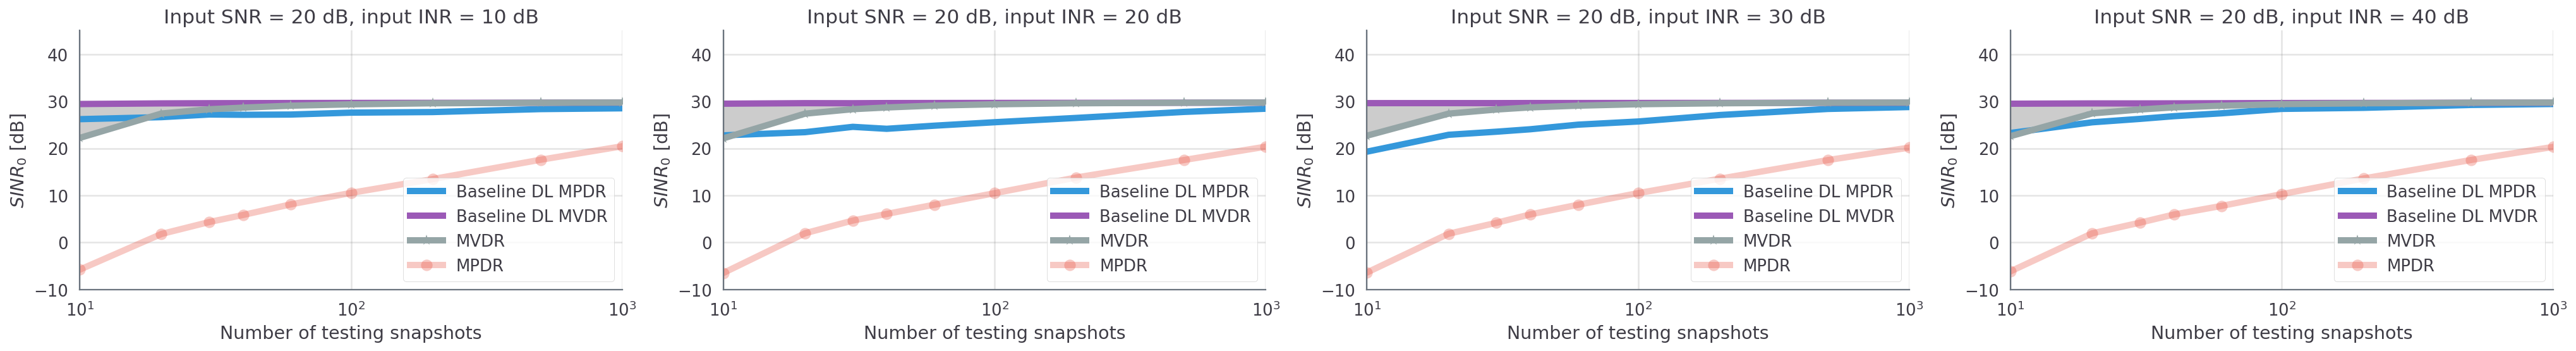

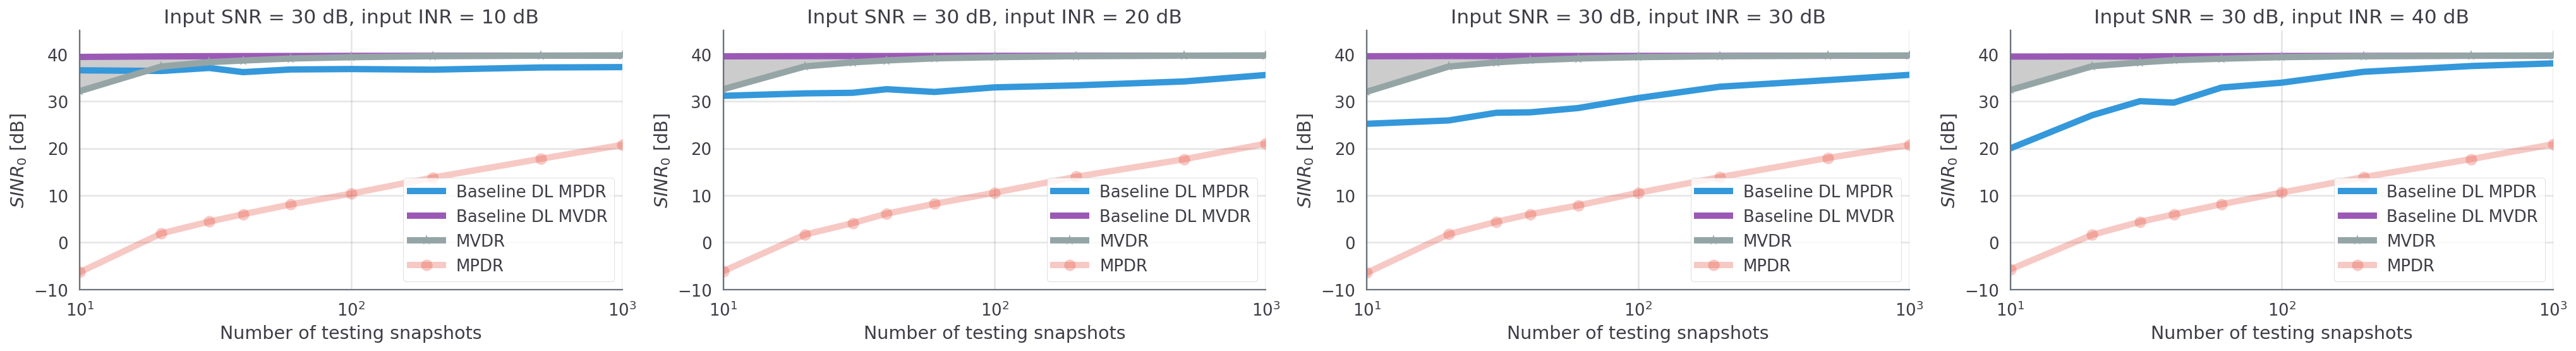

In [7]:
print("Number of training snapshots: {}".format(training_snapshots[0]))
from matplotlib.figure import figaspect
w, h = figaspect(9/16)
for i_SNR in range(n_SNRs):
    fig = plt.figure(figsize=(w*n_INRs, h));
    for i_INR in range(n_INRs):
        ax = fig.add_subplot(1, n_INRs, i_INR+1)        
        for i_training_snapshot in range(len(training_snapshots)):
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mpdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MPDR", lw=lw)
            ax.semilogx(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]), 
                        label="Baseline DL MVDR", lw=lw)
            ax.fill_between(snapshots, 10*np.log10(sinr_snr_baseline_mvdr[i_training_snapshot, i_SNR, i_INR, :]),
                                       10*np.log10(sinr_snr_mvdr[i_SNR, i_INR, :]), color='0.8')
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mvdr[i_SNR, i_INR, :]), marker="*", label="MVDR", lw=lw)
        ax.semilogx(snapshots, 10*np.log10(sinr_snr_mpdr[i_SNR, i_INR, :]), marker="o", alpha=0.3, label="MPDR", lw=lw)
        ax.legend()
        ax.set_xlim(10, 1000); ax.set_ylim(-10, 45);
        ax.set_xlabel("Number of testing snapshots");
        ax.set_ylabel(r"$SINR_0$ [dB]");
        ax.set_title("Input SNR = {} dB, input INR = {} dB".format(SNRs[i_SNR], INR_list[i_INR]))
    plt.tight_layout()    
    # fig.savefig("baseline_dl_various_interferences.jpg", dpi=600)    

### Beam Patterns

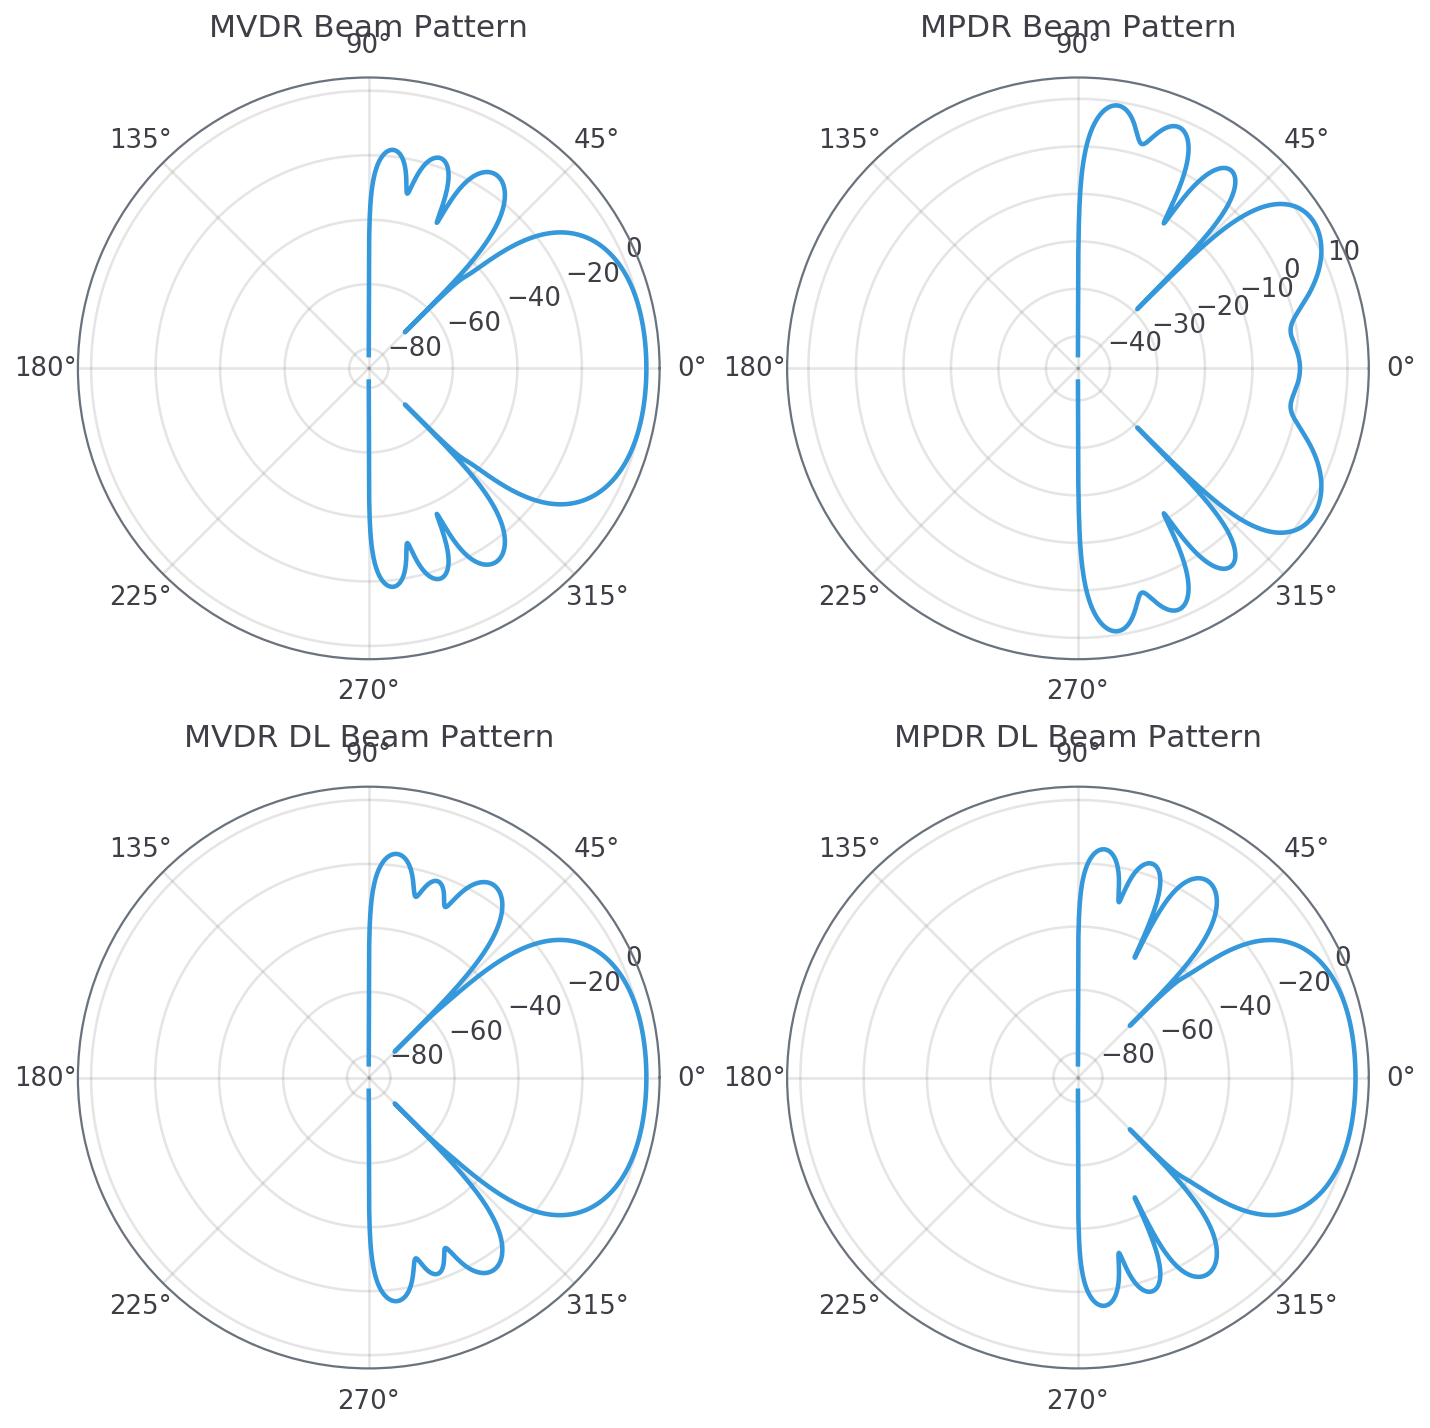

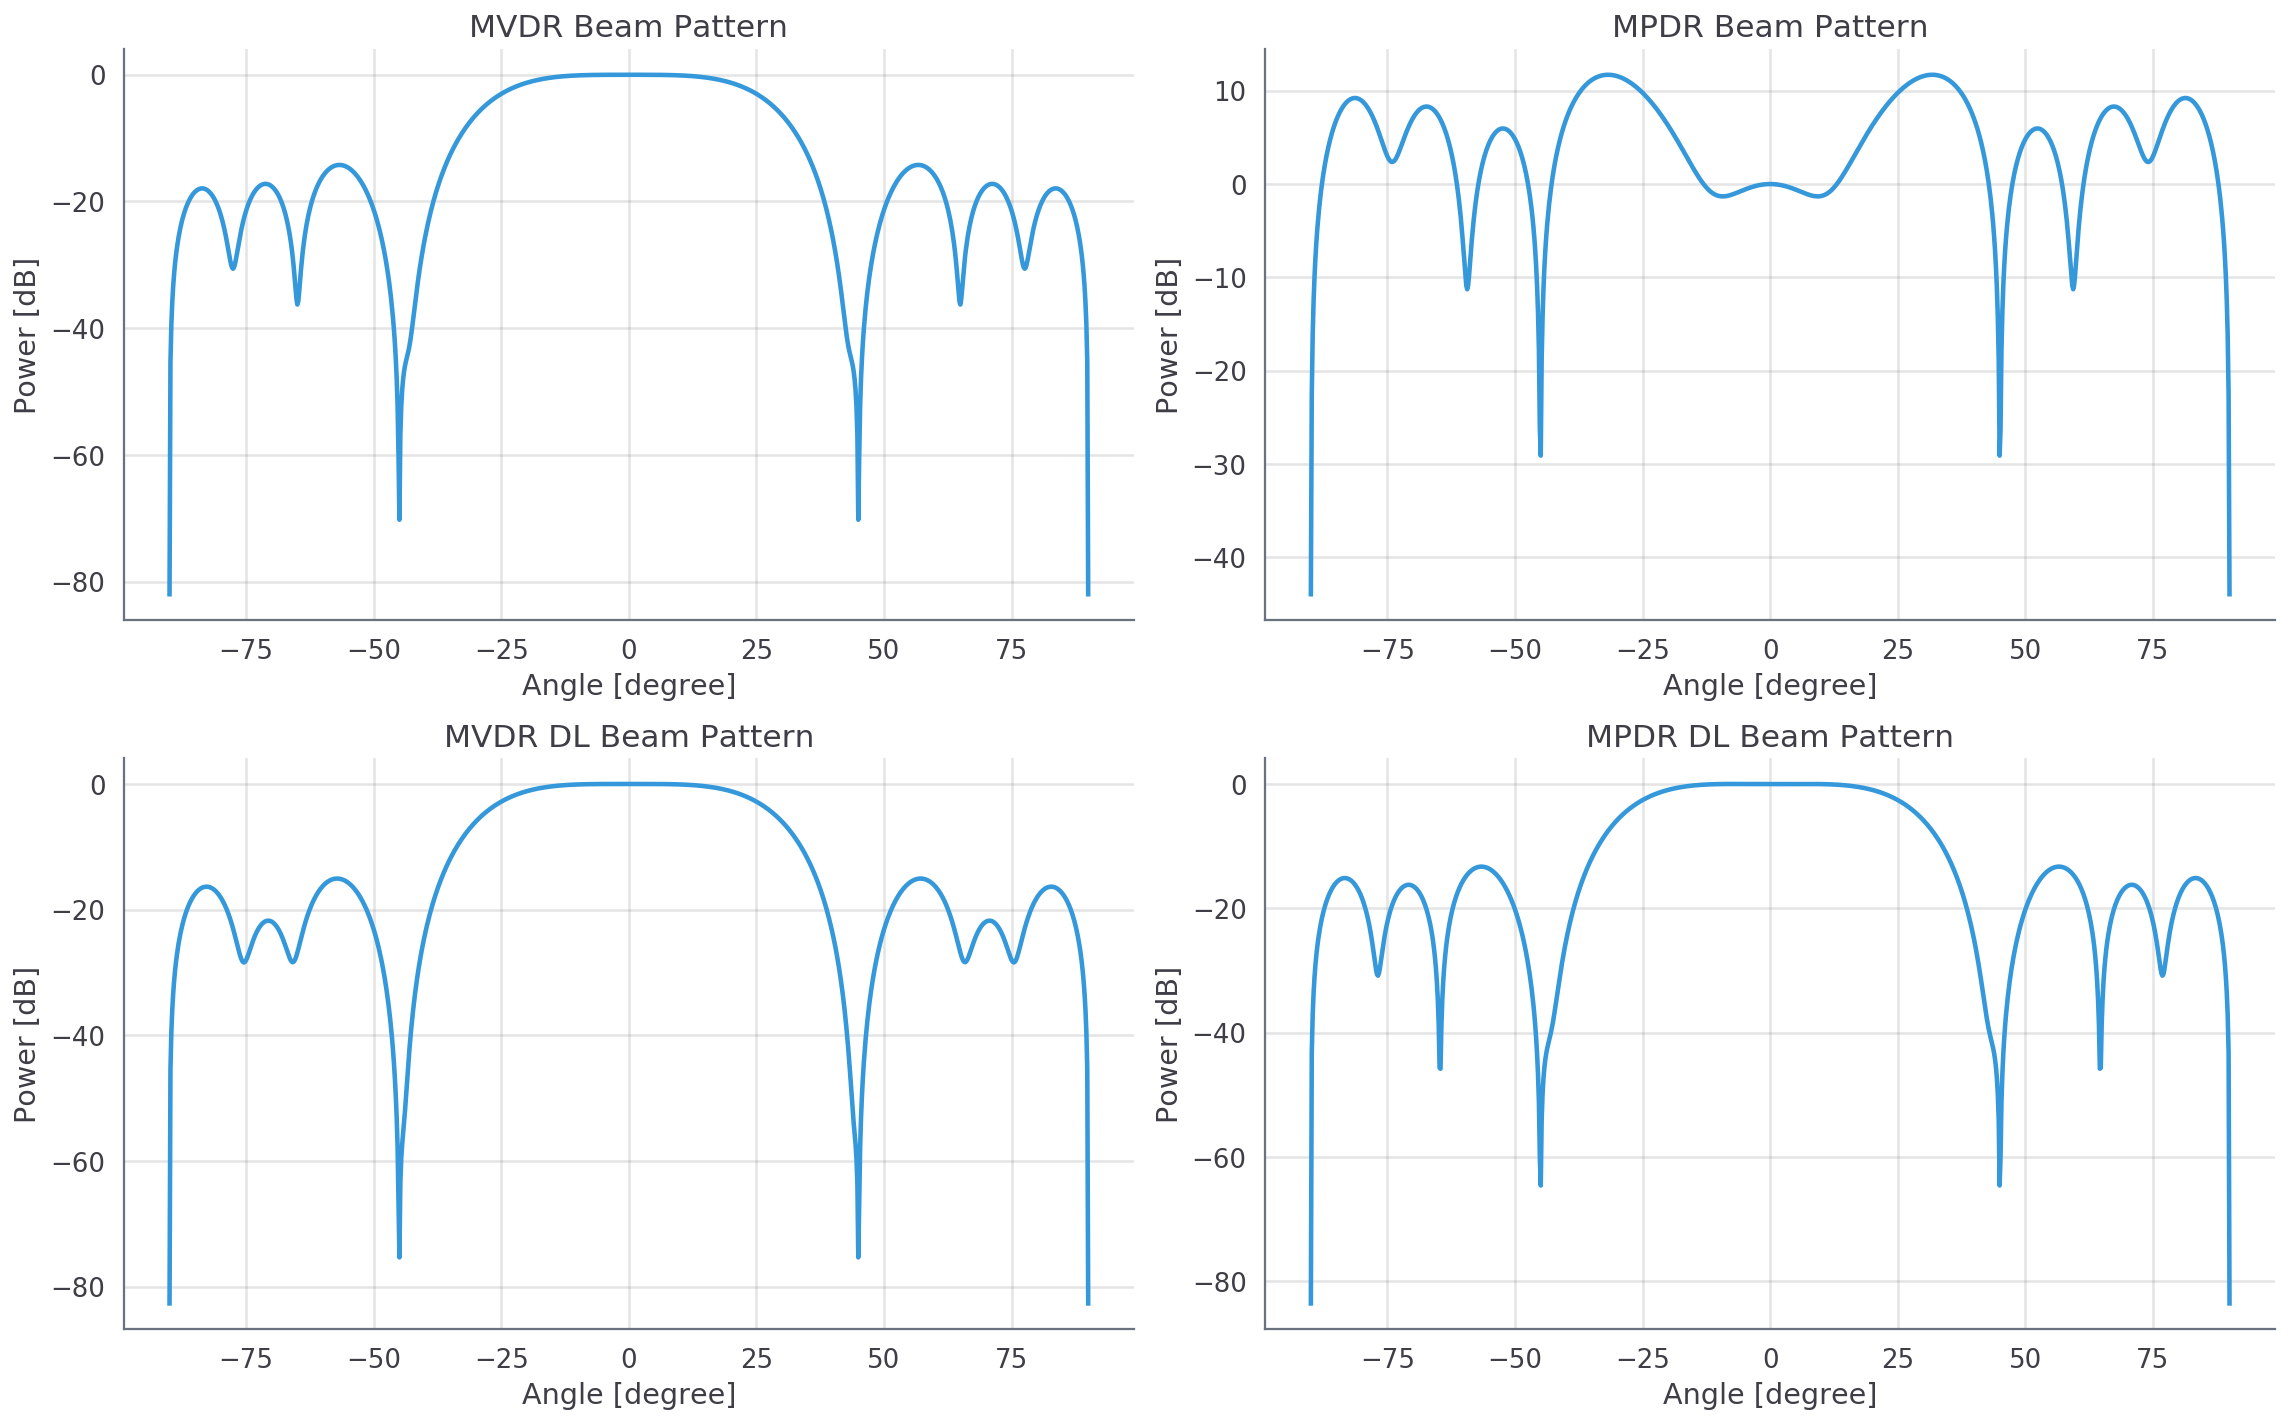

In [8]:
n_scanning_angles = 1000
scanning_angles = np.arange(-90, 90+1e-6, 180/(n_scanning_angles-1))

# MVDR
mvdr_db_beampatterns = []
mpdr_db_beampatterns = []
mvdr_dl_db_beampatterns = []
mpdr_dl_db_beampatterns = []
for i_angle in range(n_scanning_angles):
    scanning_angle = scanning_angles[i_angle]
    u = np.cos( scanning_angles[i_angle] * np.pi/180 )
    scanning_steering_vector_old = compute_steering_vector_ULA(u, microphone_array)
    scanning_steering_vector = compute_steering_vector_ULA_new(microphone_array, scanning_angle, frequency)
    assert np.linalg.norm(scanning_steering_vector - scanning_steering_vector_old) < 1e-6
    mvdr_db_beampatterns.append(20*np.log10(np.abs(wv.transpose().conjugate().dot(scanning_steering_vector)))[0][0])
    mpdr_db_beampatterns.append(20*np.log10(np.abs(wp.transpose().conjugate().dot(scanning_steering_vector)))[0][0])
    mvdr_dl_db_beampatterns.append(20*np.log10(np.abs(w_baseline_v.transpose().conjugate().dot(scanning_steering_vector))))
    mpdr_dl_db_beampatterns.append(20*np.log10(np.abs(w_baseline_p.transpose().conjugate().dot(scanning_steering_vector))))
fig = plt.figure(figsize=(10, 10)); 
ax = fig.add_subplot(221, polar=True)
ax.plot(scanning_angles*np.pi/180, mvdr_db_beampatterns); ax.set_title("MVDR Beam Pattern");
ax = fig.add_subplot(222, polar=True)
ax.plot(scanning_angles*np.pi/180, mpdr_db_beampatterns); ax.set_title("MPDR Beam Pattern");
ax = fig.add_subplot(223, polar=True)
ax.plot(scanning_angles*np.pi/180, mvdr_dl_db_beampatterns); ax.set_title("MVDR DL Beam Pattern");
ax = fig.add_subplot(224, polar=True)
ax.plot(scanning_angles*np.pi/180, mpdr_dl_db_beampatterns); ax.set_title("MPDR DL Beam Pattern");
plt.tight_layout()

fig = plt.figure(figsize=(16, 10)); 
ax = fig.add_subplot(221)
ax.plot(scanning_angles, mvdr_db_beampatterns); ax.set_title("MVDR Beam Pattern");
ax.set_xlabel("Angle [degree]"); ax.set_ylabel("Power [dB]")
ax = fig.add_subplot(222)
ax.plot(scanning_angles, mpdr_db_beampatterns); ax.set_title("MPDR Beam Pattern");
ax.set_xlabel("Angle [degree]"); ax.set_ylabel("Power [dB]")
ax = fig.add_subplot(223)
ax.plot(scanning_angles, mvdr_dl_db_beampatterns); ax.set_title("MVDR DL Beam Pattern");
ax.set_xlabel("Angle [degree]"); ax.set_ylabel("Power [dB]")
ax = fig.add_subplot(224)
ax.plot(scanning_angles, mpdr_dl_db_beampatterns); ax.set_title("MPDR DL Beam Pattern");
ax.set_xlabel("Angle [degree]"); ax.set_ylabel("Power [dB]")
plt.tight_layout()

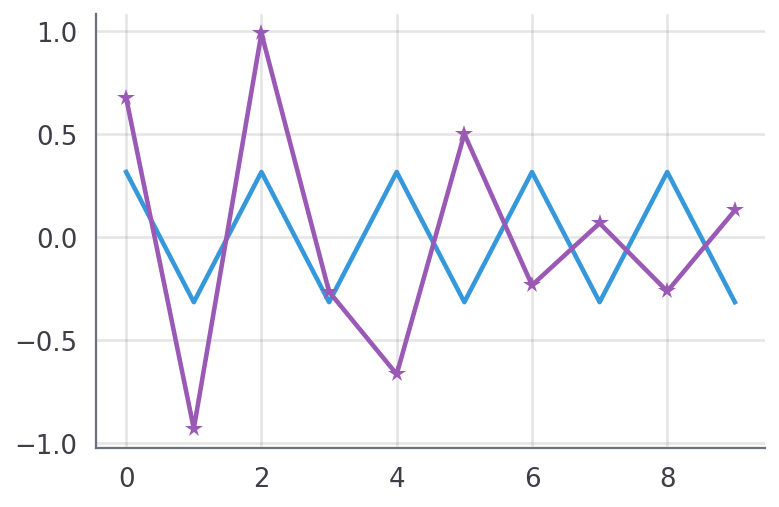

In [73]:
vs = compute_steering_vector_ULA_new(microphone_array, theta_s, frequency)
vsn = vs / np.linalg.norm(vs)
fig=plt.figure(); ax = fig.add_subplot(111)
ax.plot(np.imag(vsn))

ax.plot(np.imag(wp), marker='*')
# np.linalg.norm(np.real(vs/np.linalg.norm(vs)))